In [1]:

import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import utils

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout, Input

tf.__version__

/home/sprkzoff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sprkzoff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sprkzoff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sprkzoff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

'1.14.0'

In [4]:
os.listdir('./data')

['DJI_ema.csv',
 'DJI_STO_20period_sma10.csv',
 'DJI_modified_sma.csv',
 '.DS_Store',
 'DJI_modified_features - DJI.csv',
 'nk_fe.csv',
 'DJI_fe.csv',
 'N225withoutNULL.csv',
 'dowjone1985_2019.csv',
 'N225fillVOL.csv',
 'test_djia.csv',
 'DJI_denoise.csv',
 'N225.csv',
 'stocknews',
 'preprocessed',
 'downjone5y.csv']

In [5]:
df = pd.read_csv('data/N225withoutNULL.csv')

In [6]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1985-01-29,11843.070313,11843.070313,11843.070313,11843.070313,11843.070313,0
1,1985-01-30,11960.629883,11960.629883,11960.629883,11960.629883,11960.629883,0
2,1985-01-31,11992.309570,11992.309570,11992.309570,11992.309570,11992.309570,0
3,1985-02-01,11946.959961,11946.959961,11946.959961,11946.959961,11946.959961,0
4,1985-02-04,11891.080078,11891.080078,11891.080078,11891.080078,11891.080078,0


In [7]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000
mean,17127.378178,17230.332515,17015.456662,17123.019021,17123.019021,59729.515766
std,6094.196832,6114.941481,6070.241283,6093.569176,6093.569176,71179.395395
min,7059.770020,7100.770020,6994.899902,7054.979980,7054.979980,0.000000
25%,12331.404785,12386.577393,12270.609619,12321.304932,12321.304932,0.000000
50%,16802.924804,16923.285157,16656.660156,16790.860352,16790.860352,0.000000
75%,20442.700684,20560.332519,20328.775391,20454.067871,20454.067871,117200.000000
max,38921.648438,38957.441406,38827.710938,38915.871094,38915.871094,595200.000000


In [8]:
df = df.drop('Adj Close', axis=1)

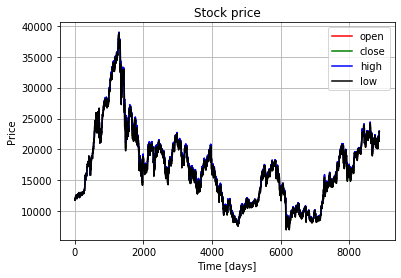

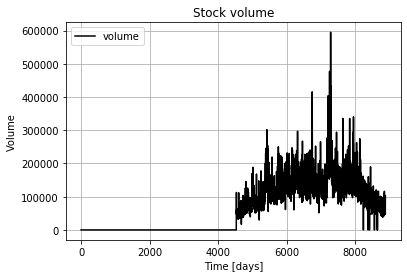

In [9]:
utils.plot_raw(df)

In [10]:
df_index = df.drop('Date', axis=1)
df_index = df_index.drop('Volume', axis=1)


cols = list(df_index.columns.values)
print('Col : ', cols)

# rearrange columns ,for training with volume
# n_cols = cols[:3] + [cols[-1]] + [cols[-2]]
# df_index = df_index[n_cols] 

# print("new Cols: ",list(df_index.columns.values))





# parameter for preprocessing #

val_set_size_percentage = 10
test_set_size_percentage = 10
seq_len = 20

#*****************************#
cols = ['Open', 'Close', 'High', 'Low']


# normalize index
df_index_norm = utils.normalize_data(df_index, cols)

# split train, val, test data

x_train, y_train, x_val, y_val, x_test, y_test = utils.load_data(df_index_norm, seq_len)

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_val.shape = ', x_val.shape)
print('y_val.shape = ', y_val.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

Col :  ['Open', 'High', 'Low', 'Close']
x_train.shape =  (7088, 19, 4)
y_train.shape =  (7088, 4)
x_val.shape =  (886, 19, 4)
y_val.shape =  (886, 4)
x_test.shape =  (886, 19, 4)
y_test.shape =  (886, 4)


/home/sprkzoff/Desktop/MultimodelStockPrediction/utils.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data_raw = stock.as_matrix()


In [11]:
print(y_train[0]); print(x_train[0]); 

[0.16136117 0.16151651 0.16010053 0.16354635]
[[0.15012612 0.15028112 0.14886365 0.15230105]
 [0.15381579 0.15397089 0.15255391 0.15599408]
 [0.15481007 0.15496521 0.15354836 0.15698927]
 [0.15338675 0.15354184 0.15212481 0.15556465]
 [0.15163293 0.15178797 0.1503707  0.15380923]
 [0.14950969 0.14966467 0.14824712 0.15168405]
 [0.1508825  0.15103752 0.14962015 0.15305811]
 [0.15319341 0.1533485  0.15193143 0.15537113]
 [0.15533421 0.15548937 0.15407259 0.15751389]
 [0.15533421 0.15548937 0.15407259 0.15751389]
 [0.15592676 0.15608194 0.15466524 0.15810698]
 [0.15585835 0.15601353 0.15459682 0.15803851]
 [0.15761533 0.15777055 0.15635408 0.15979709]
 [0.15970559 0.15986088 0.15844468 0.16188926]
 [0.15973259 0.15988788 0.15847168 0.16191628]
 [0.15996764 0.16012294 0.15870678 0.16215155]
 [0.15983364 0.15998894 0.15857275 0.16201743]
 [0.15908321 0.15923848 0.1578222  0.16126631]
 [0.15966697 0.15982226 0.15840605 0.1618506 ]]


In [12]:
df_index.head(20)

,Open,High,Low,Close
0,0.150126,0.148864,0.152301,0.150281
1,0.153816,0.152554,0.155994,0.153971
2,0.154810,0.153548,0.156989,0.154965
3,0.153387,0.152125,0.155565,0.153542
4,0.151633,0.150371,0.153809,0.151788
5,0.149510,0.148247,0.151684,0.149665
6,0.150883,0.149620,0.153058,0.151038
7,0.153193,0.151931,0.155371,0.153348
8,0.155334,0.154073,0.157514,0.155489
9,0.155334,0.154073,0.157514,0.155489


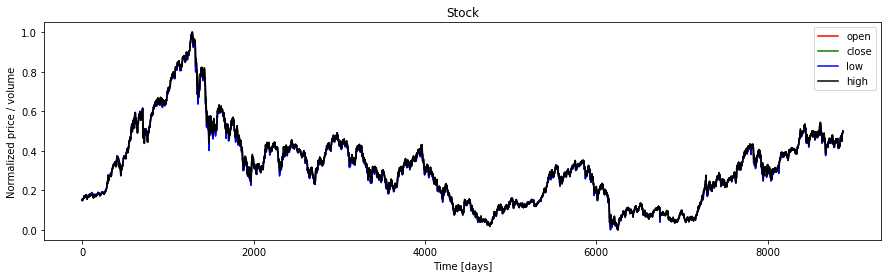

In [13]:
plt.figure(figsize=(15, 4))
plt.plot(df_index_norm['Open'], color='red', label='open')
plt.plot(df_index_norm['Close'], color='green', label='close')
plt.plot(df_index_norm['Low'], color='blue', label='low')
plt.plot(df_index_norm['High'], color='black', label='high')
plt.title('Stock')
plt.xlabel('Time [days]')
plt.ylabel('Normalized price / volume')
plt.legend(loc='best')
plt.show()

In [14]:
from tensorflow.keras import backend as K
K.clear_session()

In [15]:
from tensorflow.keras.layers import Bidirectional,TimeDistributed,BatchNormalization,Flatten
n_steps = seq_len - 1

def get_bi_gru():
    
    input1 = Input(shape=(19,4,))
    x = Bidirectional(LSTM(200,activation='relu', return_sequences=True))(input1)
    x = TimeDistributed(BatchNormalization())(x)
    x = LSTM(200,activation='relu')(x)
    #x = Dense(200,activation='relu')(x)
    x = (BatchNormalization())(x)
    out = Dense(4,activation='linear')(x)

    
    
    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(0.005),
                loss='mse',
                metrics=['mse'])   
    
    return model

In [16]:
model = get_bi_gru()
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19, 4)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 19, 400)           328000    
_________________________________________________________________
time_distributed (TimeDistri (None, 19, 400)           1600      
___________________________________________________

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
print('start training ')


weight_path_model = "saved_model/baseline.h5"
callbacks_list_model = [
    ModelCheckpoint(
             weight_path_model,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=2
        ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, min_lr=0.0001)
]

#################
batch_size = 256
epochs = 100
#################

history = model.fit(x_train, y_train, epochs=epochs, verbose=2, callbacks=callbacks_list_model,
          validation_data=(x_val, y_val),batch_size=batch_size) #batch_size=batch_size




start training 
Train on 7088 samples, validate on 886 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100

Epoch 00001: val_loss improved from inf to 1451.43454, saving model to saved_model/baseline.h5
7088/7088 - 8s - loss: 0.5027 - mean_squared_error: 0.5027 - val_loss: 1451.4345 - val_mean_squared_error: 1451.4346
Epoch 2/100

Epoch 00002: val_loss improved from 1451.43454 to 0.12176, saving model to saved_model/baseline.h5
7088/7088 - 7s - loss: 0.0193 - mean_squared_error: 0.0193 - val_loss: 0.1218 - val_mean_squared_error: 0.1218
Epoch 3/100

Epoch 00003: val_loss improved from 0.12176 to 0.02196, saving model to saved_model/baseline.h5
7088/7088 - 7s - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0220 - val_mean_squared_error: 0.0220
Epoch 4/100

Epoch 00004: val_loss improved from 0.02196 to 0.02002, saving model to saved_model/baseline.h5
7088/7088 - 7s - loss: 0.0011 - mean_squared_error: 0.0011 - val_l

Epoch 37/100

Epoch 00037: val_loss improved from 0.00055 to 0.00038, saving model to saved_model/baseline.h5
7088/7088 - 7s - loss: 3.8554e-04 - mean_squared_error: 3.8554e-04 - val_loss: 3.8071e-04 - val_mean_squared_error: 3.8071e-04
Epoch 38/100

Epoch 00038: val_loss improved from 0.00038 to 0.00028, saving model to saved_model/baseline.h5
7088/7088 - 7s - loss: 5.5670e-04 - mean_squared_error: 5.5670e-04 - val_loss: 2.7751e-04 - val_mean_squared_error: 2.7751e-04
Epoch 39/100

Epoch 00039: val_loss did not improve from 0.00028
7088/7088 - 7s - loss: 5.2954e-04 - mean_squared_error: 5.2954e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 40/100

Epoch 00040: val_loss improved from 0.00028 to 0.00021, saving model to saved_model/baseline.h5
7088/7088 - 8s - loss: 4.8021e-04 - mean_squared_error: 4.8021e-04 - val_loss: 2.1127e-04 - val_mean_squared_error: 2.1127e-04
Epoch 41/100

Epoch 00041: val_loss did not improve from 0.00021
7088/7088 - 8s - loss: 6.7484e-04 - mean

Epoch 78/100

Epoch 00078: val_loss improved from 0.00011 to 0.00011, saving model to saved_model/baseline.h5
7088/7088 - 8s - loss: 5.0843e-04 - mean_squared_error: 5.0843e-04 - val_loss: 1.0618e-04 - val_mean_squared_error: 1.0618e-04
Epoch 79/100

Epoch 00079: val_loss did not improve from 0.00011
7088/7088 - 8s - loss: 4.3724e-04 - mean_squared_error: 4.3724e-04 - val_loss: 1.1750e-04 - val_mean_squared_error: 1.1750e-04
Epoch 80/100

Epoch 00080: val_loss did not improve from 0.00011
7088/7088 - 8s - loss: 3.7972e-04 - mean_squared_error: 3.7972e-04 - val_loss: 2.5280e-04 - val_mean_squared_error: 2.5280e-04
Epoch 81/100

Epoch 00081: val_loss did not improve from 0.00011
7088/7088 - 7s - loss: 3.9429e-04 - mean_squared_error: 3.9429e-04 - val_loss: 1.4665e-04 - val_mean_squared_error: 1.4665e-04
Epoch 82/100

Epoch 00082: val_loss did not improve from 0.00011
7088/7088 - 8s - loss: 3.3588e-04 - mean_squared_error: 3.3588e-04 - val_loss: 1.2317e-04 - val_mean_squared_error: 1.2317

In [18]:
#model.save("saved_model/model00epVolume.h5")

In [19]:
#from tensorflow.keras.models import load_model
#model = load_model("saved_model/model500ep_novolume.h5")


In [20]:
x_train.shape
y_train.shape

(7088, 4)

In [21]:
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)
y_test_pred = model.predict(x_test)

In [22]:
print(y_test_pred[0])

[0.30294895 0.30521488 0.2936093  0.28341836]


In [23]:
def plot_compare(x):
    Col = {'Open':0, 'High':1, 'Low':2, 'Close':3}
    ft = Col[x]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)

    plt.plot(np.arange(y_train.shape[0]), y_train[:, ft], color='blue', label='train target')

    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_val.shape[0]), y_val[:, ft], 
             color='gray', label='val target')
    plt.plot(np.arange(y_train.shape[0] + y_val.shape[0], y_train.shape[0] + y_val.shape[0] + y_test.shape[0]),
            y_test[:, ft], color='black', label='test target')
    plt.plot(np.arange(y_train_pred.shape[0]), y_train_pred[:, ft],
            color='red', label='train prediction') 
    plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0] + y_val_pred.shape[0]),
            y_val_pred[:, ft], color='orange', label='val prediction')
    plt.plot(np.arange(y_train_pred.shape[0] + y_val_pred.shape[0],
            y_train_pred.shape[0] + y_val_pred.shape[0] + y_test_pred.shape[0]),
            y_test_pred[:, ft], color ='green', label='test prediction')
    plt.title('past and future stock price')
    plt.xlabel('Time [Days]')
    plt.ylabel('Normalized price')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0]),
            y_test[:, ft], color='black', label='test target')
    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test_pred.shape[0]),
            y_test_pred[:, ft], color='green', label='test prediction')
    plt.title('future stock prices '+x)
    plt.xlabel('Time [Days]')
    plt.ylabel('Normalized price')
    plt.legend(loc='best')


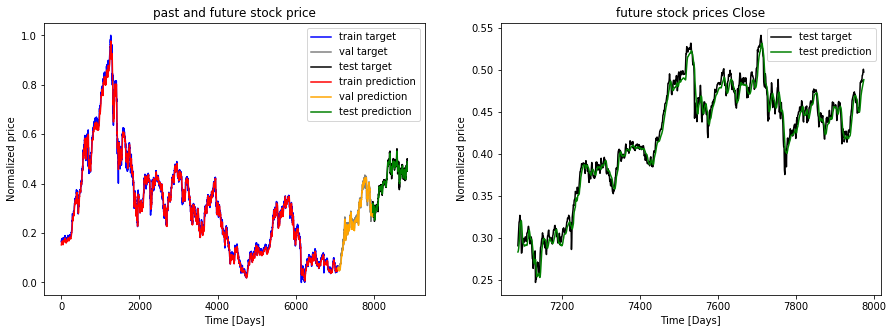

In [24]:
plot_compare('Close')

In [25]:
model.evaluate(x_test,y_test)

886/886 [==============================] - 0s 457us/sample - loss: 1.2937e-04 - mean_squared_error: 1.2937e-04


[0.00012936620160639833, 0.00012936622]

In [26]:
model.evaluate(x_val,y_val)

886/886 [==============================] - 0s 506us/sample - loss: 2.0719e-04 - mean_squared_error: 2.0719e-04


[0.0002071908085830888, 0.00020719082]

In [27]:
model.evaluate(x_train,y_train)

7088/7088 [==============================] - 4s 533us/sample - loss: 3.2163e-04 - mean_squared_error: 3.2163e-04


[0.0003216322424714338, 0.0003216322]